Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_rgi.pckl

This is a notebook to demonstrate in a 'stand-alone' version how to do a diffuse astrophysical flux fit and LLH ratio test

Further reference: https://pos.sissa.it/395/1185/ , especially sec. 2.2

# Imports

In [1]:
import pickle
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from matplotlib.colors import LogNorm
from scipy.interpolate import InterpolatedUnivariateSpline

import pandas as pd
from fluxes import power_law
from settings import BASEPATH, slightly_change_color
from os.path import join


warnings.filterwarnings("ignore")


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
sns.set_palette(sns.blend_palette(["tomato", "orange", "seagreen", "tab:blue", "black"], n_colors=7))
sns.blend_palette(["tomato", "orange", "seagreen", "tab:blue", "black"], n_colors=7)


[(1.0, 0.38823529411764707, 0.2784313725490196),
 (1.0, 0.5587543252595156, 0.09499423298731258),
 (0.7267973856209151, 0.6130718954248366, 0.11372549019607843),
 (0.17993079584775087, 0.5444828911956939, 0.34403690888119953),
 (0.1411764705882353, 0.49281045751633984, 0.5843137254901961),
 (0.08009227220299885, 0.3074509803921569, 0.46505190311418687),
 (0.0, 0.0, 0.0)]

# Source parameters

In [25]:

wb_bound = 2E-8

In [3]:
# livetime of 10yrs in seconds
LIVETIME = 365 * 10 * 24 * 3600
# Normalization energy of power law (E/E0)^gamma
E0 = 1E5
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
GAMMA = 2.37 # spectral index
PHI_0 = 1.44E-18 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s / sr

# Source flux definition

$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [4]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-18

    parameters:
    aeff_factor: array
        effective area * bin widths
    emids: array
        value of the mids of the true neutrino energy / GeV, matching the binning of aeff_factor
    E0: number
        see above, normalization energy of the flux
    gamma: number
        see above, spectral index of the neutrino flux
    phi_scaling: number
        see above, factor for normalization

    returns:
    number of events expected for given power-law flux of astrophysical neutrinos
    as a function of log10(reconstructed energy / GeV)
    (dimensionality depends on aeff_factor, eg. it might have a dimension in sin(dec))
    """
    return aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling

In [5]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [6]:
# with two dimensions: sindec, energy
def aeff_eval_e_sd(aeff, sindec_width, e_width):
    """calculate the aeff factor based on the 'raw' effective area, sindec and energy binning
    parameters:
    aeff: array, 2D
        effective area in m^2 as a function of sin(dec) and log10(true energy)
    sindec_width: array
        bin width of sin(dec)
    e_width: array
        bin width of true energy (Not Log10!)

    returns:
    aeff factor
    """
    return (aeff * sindec_width).T * e_width * 2*np.pi

# Cosmogenic fluxes

In [7]:
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [8]:
cosmogenic = pd.read_csv("../../resources/alexandra/fig4.csv", skipinitialspace=True)
cosmogenic.E2phi /= 3 # only one flavor
cosmogenic["phi"] = cosmogenic.E2phi / (cosmogenic.E**2)

cosmo_splines = {}
for k in cosmogenic.key.unique():
    cosmo_splines[k] = InterpolatedUnivariateSpline(
        cosmogenic.E.loc[cosmogenic.key == k],
        cosmogenic.E2phi.loc[cosmogenic.key == k],
        ext="zeros",
    )


In [9]:
def skewy(x, *p):
    return p[0] * skewnorm.logpdf(x, p[1], loc=p[2], scale=p[3])

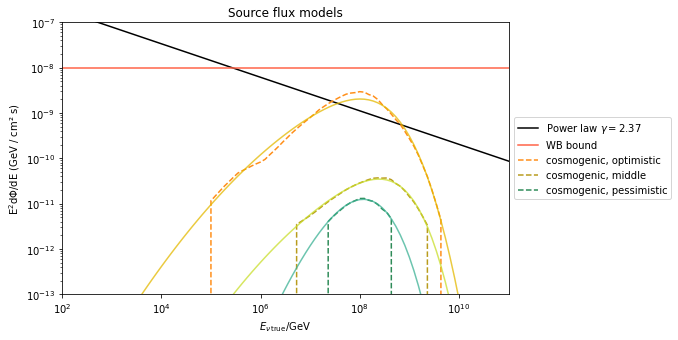

In [10]:
x_evals = np.logspace(2, 11, 100)

f, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Source flux models")
pl = power_law(x_evals, E0, GAMMA, PHI_0)
ax.plot(
    x_evals,
    pl * (x_evals**2),
    label=rf"Power law $\gamma=${GAMMA}",
    color="k",
    alpha=1,
)

ax.plot(x_evals, wb_bound * np.ones_like(x_evals), label="WB bound")
cosmo_fits = {}
for k in cosmogenic.key.unique():
    p = ax.plot(
        x_evals,
        cosmo_splines[k](x_evals),
        ls="--",
        label="cosmogenic, " + k,
    )

    params, cov = curve_fit(
        skewy,
        np.log10(cosmogenic.E.loc[cosmogenic.key == k]),
        np.log10(cosmogenic.E2phi.loc[cosmogenic.key == k]),
        p0=[3, -2, 9, 1]
    )
    cosmo_fits[k] = params
    plt.plot(
        x_evals, 
        10 ** skewy(np.log10(x_evals), *params),
        color=slightly_change_color(p[0].get_color(), amount=0.05),
        alpha=0.75
    )

ax.set_yscale("log")
ax.set_ylabel(rf"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_xlim(1e2, 1e11)
ax.set_ylim(1E-13, 1E-7)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


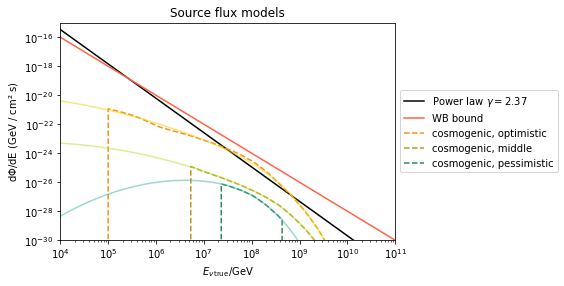

In [11]:
x_evals = np.logspace(2, 11, 100)

f, ax = plt.subplots()
ax.set_title("Source flux models")
pl = power_law(x_evals, E0, GAMMA, PHI_0)
ax.plot(
    x_evals,
    pl,
    label=rf"Power law $\gamma=${GAMMA}",
    color="k",
    alpha=1,
)

ax.plot(x_evals, wb_bound * np.ones_like(x_evals) / (x_evals**2), label="WB bound")

for k in cosmogenic.key.unique():
    p = ax.plot(
        x_evals,
        cosmo_splines[k](x_evals) / (x_evals**2),
        ls="--",
        label="cosmogenic, " + k,
    )
    ax.plot(
        x_evals,
        10 ** skewy(np.log10(x_evals), *cosmo_fits[k]) / (x_evals**2),
        alpha=0.5, color=slightly_change_color(p[0].get_color(), amount=0.07)
    )

ax.set_yscale("log")
ax.set_ylabel(rf"$\rm d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_xlim(1e4, 1e11)
ax.set_ylim(1E-30, 1E-15)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


# Get the effective area

In [12]:
with open(
    join(BASEPATH, "resources/tabulated_logE_sindec_aeff_upgoing.pckl"), "rb"
) as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
det_key = "IceCube"
sindec_bins = np.linspace(-1, 1, num=1 + np.shape(aeff_2d[det_key])[-1])

# get the mids of the log(true energy / GeV) binning
logE_mids = get_mids(logE_bins)

# get the binning also in true energy
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

# same for sin(dec) binning
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

aeff_factor = aeff_eval_e_sd(aeff_2d[det_key], sindec_width, ewidth) * LIVETIME

# asimov data
# in reconstructed energy
k_s = astro_flux(
    aeff_factor,
    emids,
    E0,
    GAMMA,
    1,
)
k_wb = astro_flux(aeff_factor, emids, E0, 2, 1 / 1.44)
print("Signal:", np.sum(k_s))  # ~2888
print("Signal WB:", np.sum(k_wb))  # ~2888


Signal: 2888.900298720721
Signal WB: 1032.732570033037


In [13]:
with open(
    join(BASEPATH, "resources/alexandra/tabulated_logE_sindec_aeff_GRAND.pckl"), "rb"
) as f:
    logE_bins_grand, _, aeff_2d_grand = pickle.load(f)

# get the binning also in true energy
ebins_grand = np.power(10, logE_bins_grand)
emids_grand = get_mids(ebins_grand)
ewidth_grand = np.diff(ebins_grand)
# get the mids of the log(true energy / GeV) binning
logE_mids_grand = get_mids(logE_bins_grand)


for det_key in ["Grand_1", "GRAND-Plenum-1", "NP"]:
    print(det_key)
    sindec_bins_grand = np.linspace(-1, 1, num=1 + np.shape(aeff_2d_grand[det_key])[-1])

    # same for sin(dec) binning
    sindec_mids_grand = get_mids(sindec_bins_grand)
    sindec_width_grand = np.diff(sindec_bins_grand)
    aeff_2d_grand_test = (
        np.where(np.abs(sindec_mids) < np.sin(np.deg2rad(2)), aeff_2d_grand["NP"], 0) # small horizont selection
        if det_key == "NP"
        else aeff_2d_grand[det_key] # wider horizont selection
    )

    aeff_factor = (
        aeff_eval_e_sd(aeff_2d_grand_test, sindec_width_grand, ewidth_grand)
        * LIVETIME  # / 10 / 20
    )

    # asimov data
    # in reconstructed energy
    k_s = astro_flux(
        aeff_factor,
        emids_grand,
        E0,
        GAMMA,  ## FIT PARAMETER
        1,  ## FIT PARAMETER
    )

    k_wb = astro_flux(aeff_factor, emids_grand, E0, 2, 1 / 1.44)

    print("Signal WB:", np.sum(k_wb))
    print("Signal PL:", np.sum(k_s))
    for k in cosmo_splines.keys():
        print(
            "Signal cosmo " + k + ":",
            np.sum(aeff_factor * cosmo_splines[k](emids_grand) / (emids_grand**2)),
        )
    print("- " * 5)


Grand_1
Signal WB: 24.901468479709735
Signal PL: 1.2772831289839437
Signal cosmo optimistic: 1.731604045149811
Signal cosmo middle: 0.04279165442335672
Signal cosmo pessimistic: 0.0067157495164139845
- - - - - 
GRAND-Plenum-1
Signal WB: 246.00880394969266
Signal PL: 12.618649182175611
Signal cosmo optimistic: 17.107016817456387
Signal cosmo middle: 0.4227511213764881
Signal cosmo pessimistic: 0.06634683040901487
- - - - - 
NP
Signal WB: 24.49323739737818
Signal PL: 1.2563435336097268
Signal cosmo optimistic: 1.7032163782097192
Signal cosmo middle: 0.042090134213243875
Signal cosmo pessimistic: 0.006605652487558553
- - - - - 


# compare

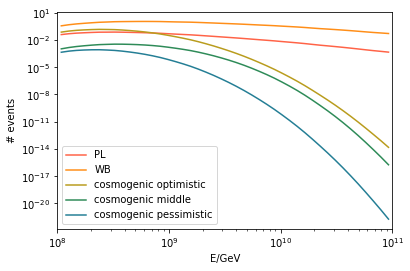

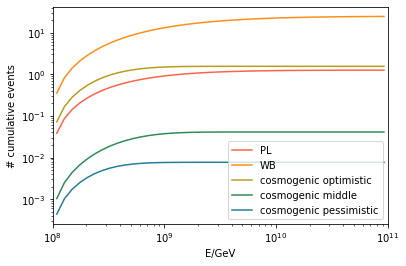

In [14]:
plt.figure()
plt.plot(emids_grand, k_s.sum(axis=0), label="PL")
plt.plot(emids_grand, k_wb.sum(axis=0), label="WB")

plt.plot()
for k, params in cosmo_fits.items():
    plt.plot(
        emids_grand,
        np.sum(
            aeff_factor * (10 ** skewy(np.log10(emids_grand), *params)) / (emids_grand**2),
            axis=0,
        ),
        label="cosmogenic "+k,
    )

plt.yscale("log")
plt.xscale("log")
plt.ylabel("# events")
plt.xlabel("E/GeV")
plt.xlim(1E8, 1E11)
plt.legend(loc=0)

plt.figure()
plt.plot(emids_grand, np.cumsum(k_s.sum(axis=0)), label="PL")
plt.plot(emids_grand, np.cumsum(k_wb.sum(axis=0)), label="WB")

plt.plot()
for k, params in cosmo_fits.items():
    plt.plot(
        emids_grand,
        np.cumsum(np.sum(
            aeff_factor * (10 ** skewy(np.log10(emids_grand), *params)) / (emids_grand**2),
            axis=0,
        )),
        label="cosmogenic "+k,
    )

plt.yscale("log")
plt.xscale("log")
plt.ylabel("# cumulative events")
plt.xlabel("E/GeV")
plt.xlim(1E8, 1E11)
plt.legend(loc=0)


Text(0, 0.5, 'Aeff / cm²')

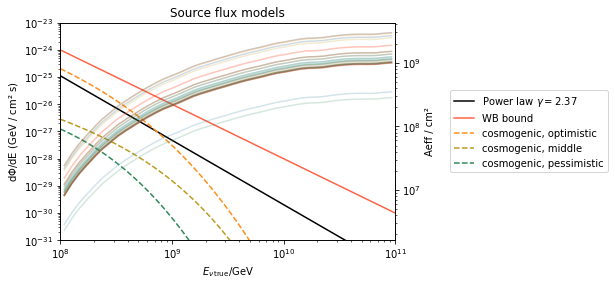

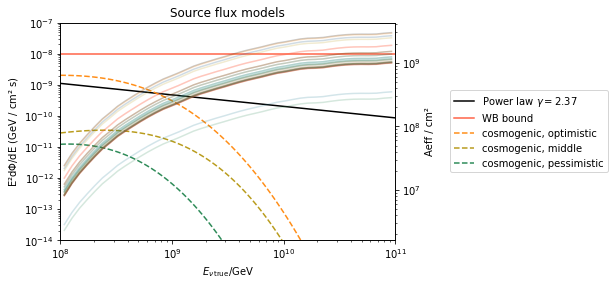

In [15]:
x_evals = np.logspace(8, 11, 100)

f, ax = plt.subplots()
ax.set_title("Source flux models")


pl = power_law(x_evals, E0, GAMMA, PHI_0)
ax.plot(
    x_evals,
    pl,
    label=rf"Power law $\gamma=${GAMMA}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, wb_bound * np.ones_like(x_evals) / (x_evals**2), label="WB bound")

for k, params in cosmo_fits.items():
    ax.plot(
        x_evals,
        (10 ** skewy(np.log10(x_evals), *params)) / (x_evals**2),
        ls="--",
        label="cosmogenic, " + k,
    )

ax.set_yscale("log")
ax.set_ylabel(rf"$\rm d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-31, 1e-23)
ax.set_xlim(1e8, 1e11)
ax.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))


ax2 = ax.twinx()
for i in range(len(aeff_2d_grand["Grand_1"][0])):
    ax2.plot(emids_grand, aeff_2d_grand["Grand_1"][:, i], alpha=0.2)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("Aeff / cm²")


f, ax = plt.subplots()
ax.set_title("Source flux models")
pl = power_law(x_evals, E0, GAMMA, PHI_0)
ax.plot(
    x_evals,
    pl * (x_evals**2),
    label=rf"Power law $\gamma=${GAMMA}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, wb_bound * np.ones_like(x_evals), label="WB bound")
for k, params in cosmo_fits.items():
    ax.plot(
        x_evals,
        10 ** skewy(np.log10(x_evals), *params),
        ls="--",
        label="cosmogenic, " + k,
    )

ax.set_yscale("log")
ax.set_ylabel(rf"$\rm E² d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-14, 1e-7)
ax.set_xlim(1e8, 1e11)
ax.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))


ax2 = ax.twinx()
for i in range(len(aeff_2d_grand["Grand_1"][0])):
    ax2.plot(emids_grand, aeff_2d_grand["Grand_1"][:, i], alpha=0.2)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("Aeff / cm²")


Text(0, 0.5, 'Aeff / cm²')

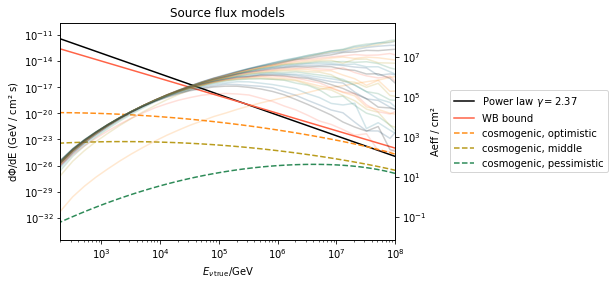

In [16]:
x_evals = np.logspace(2, 8, 100)

f, ax = plt.subplots()
ax.set_title("Source flux models")


pl = power_law(x_evals, E0, GAMMA, PHI_0)
ax.plot(
    x_evals,
    pl,
    label=rf"Power law $\gamma=${GAMMA}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, wb_bound * np.ones_like(x_evals) / (x_evals**2), label="WB bound")

for k, params in cosmo_fits.items():
    ax.plot(
        x_evals,
        (10 ** skewy(np.log10(x_evals), *params)) / (x_evals**2),
        ls="--",
        label="cosmogenic, " + k,
    )

ax.set_yscale("log")
ax.set_ylabel(rf"$\rm d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_xlim(2e2, 1e8)
ax.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))


ax2 = ax.twinx()
for i in range(len(aeff_2d["IceCube"][0])):
    ax2.plot(emids, aeff_2d["IceCube"][:, i], alpha=0.2)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("Aeff / cm²")


# cross-check WB event numbers

In [17]:
dec_acceptance = pd.read_csv("../../resources/dec_acceptance.csv", skipinitialspace=True)
dec_acceptance

,d,acc
0,-4.629922,0.032941
1,-4.541564,0.036957
2,-4.453207,0.041351
3,-4.364849,0.045950
4,-4.276491,0.050824
...,...,...
139,4.286201,0.000161
140,4.374559,0.000127
141,4.462917,0.000127
142,4.551275,0.000127


In [22]:
## events per year for 10k detector from WB bound (2E-8 * E-2 spectrum) * 3 yr * 20 (-> 200k) // poisson limit (2.44)
2E-8 / (np.sum(np.diff(dec_acceptance.d) * get_mids(dec_acceptance.acc.values)) * 3 * 20 / 2.44)
# should be ~4E-10, check!!

4.1270153545229434e-10

In [23]:
exposure = pd.read_csv("../../resources/exposure.csv", skipinitialspace=True)
exposure # E/ GeV ; exposure / cm² s sr


,E,exposure
0,9.474720e+07,1.373210e+15
1,1.327210e+08,7.002980e+15
2,1.861830e+08,1.164230e+16
3,2.611230e+08,2.302840e+16
4,3.663980e+08,3.162280e+16
5,5.140970e+08,4.476550e+16
6,7.213430e+08,6.282220e+16
7,1.012370e+09,7.345780e+16
8,1.420660e+09,9.369110e+16
9,1.993720e+09,1.149150e+17


In [24]:
dE = np.diff(exposure.E.values)
dE = np.concatenate([[dE[0]], dE])
(wb_bound / (exposure.E **2) * exposure.exposure * dE).sum() # / GeV cm² s sr

2.4795114969218917

(-10.0, 15.0)

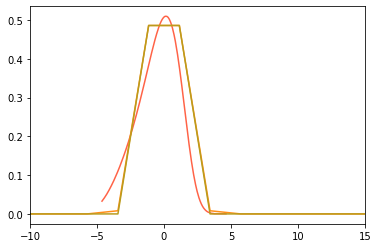

In [28]:
plt.plot(dec_acceptance.d, dec_acceptance.acc)
div = 1.5E10
plt.plot(np.rad2deg(np.arcsin(sindec_mids)), aeff_2d_grand["NP"][20] / div)
plt.plot(np.rad2deg(np.arcsin(sindec_mids)), np.where(np.abs(sindec_mids) < np.sin(np.deg2rad(2)), aeff_2d_grand["NP"][20] / div, 0)) 
plt.xlim(-10, 15)

In [33]:
b = sindec_mids_grand[aeff_2d_grand["NP"][20]>1E11]
(np.rad2deg(np.arcsin(b[-1])) - np.rad2deg(np.arcsin(b[0]))) #* 2.5

16.1089302827442

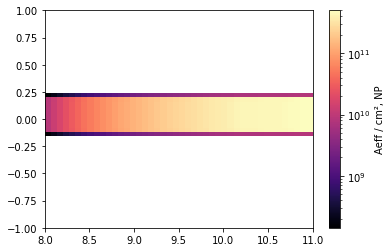

In [35]:
plt.figure()
plt.pcolormesh(
    logE_bins_grand,
    sindec_bins_grand,
    aeff_2d_grand["NP"].T,
    norm=LogNorm(),
    cmap="magma",
)
cb = plt.colorbar()
cb.set_label("Aeff / cm², NP")

Text(0.5, 0, 'log10(E/GeV)')

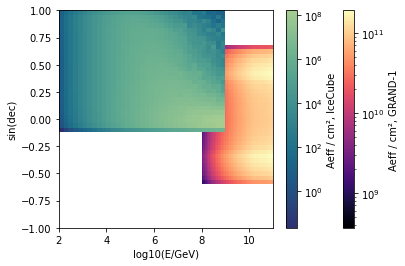

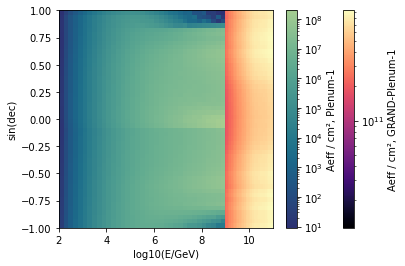

In [36]:
plt.figure()
plt.pcolormesh(
    logE_bins_grand,
    sindec_bins_grand,
    aeff_2d_grand["Grand_1"].T,
    norm=LogNorm(),
    cmap="magma",
)
cb = plt.colorbar()
cb.set_label("Aeff / cm², GRAND-1")
plt.pcolormesh(
    logE_bins, sindec_bins, aeff_2d["IceCube"].T, norm=LogNorm(), cmap="crest_r"
)
cb = plt.colorbar()
cb.set_label("Aeff / cm², IceCube")

plt.ylabel("sin(dec)")
plt.xlabel("log10(E/GeV)")

plt.figure()
plt.pcolormesh(
    logE_bins_grand,
    sindec_bins_grand,
    aeff_2d_grand["GRAND-Plenum-1"].T,
    norm=LogNorm(),
    cmap="magma",
)
cb = plt.colorbar()
cb.set_label("Aeff / cm², GRAND-Plenum-1")
plt.pcolormesh(
    logE_bins, sindec_bins, aeff_2d["Plenum-1"].T, norm=LogNorm(), cmap="crest_r"
)
cb = plt.colorbar()
cb.set_label("Aeff / cm², Plenum-1")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E/GeV)")

# Full nominal (=Asimov) histograms in  sin(dec) - log(E)

Fit parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, gamma, of the astrophysical neutrino flux (signal), $\gamma$

In [ ]:
with open(join(BASEPATH, "resources/alexandra/tabulated_logE_sindec_aeff_GRAND.pckl"), "rb") as f:
    logE_bins_grand, _, aeff_2d_grand = pickle.load(f)

det_key = "Grand_1"
sindec_bins_grand = np.linspace(-1, 1, num= 1+np.shape(aeff_2d_grand_test)[-1])

# get the mids of the log(true energy / GeV) binning
logE_mids_grand = get_mids(logE_bins_grand)

# get the binning also in true energy
ebins_grand = np.power(10, logE_bins_grand)
emids_grand = get_mids(ebins_grand)
ewidth_grand = np.diff(ebins_grand)

# same for sin(dec) binning
sindec_mids_grand = get_mids(sindec_bins_grand)
sindec_width_grand = np.diff(sindec_bins_grand)

aeff_factor = (
    aeff_eval_e_sd(aeff_2d_grand[det_key], sindec_width_grand, ewidth_grand) * LIVETIME
)

# asimov data
# in reconstructed energy
k_s = astro_flux(
    aeff_factor,
    emids,
    E0,
    GAMMA, ## FIT PARAMETER
    1, ## FIT PARAMETER
)

print("Signal:", np.sum(k_s)) # ~2888




Signal: 195.11888900531312


## some plotting of the event distribution

Text(0.5, 1.0, 'Signal astrophysical flux')

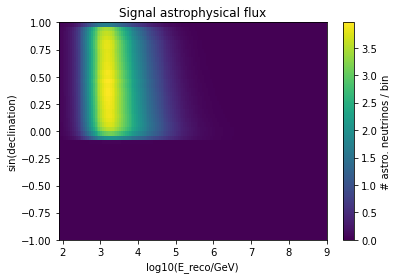

In [21]:
## signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_s)
cb = plt.colorbar()
cb.set_label("# astro. neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal astrophysical flux")

Text(0.5, 1.0, 'Background atmospheric flux')

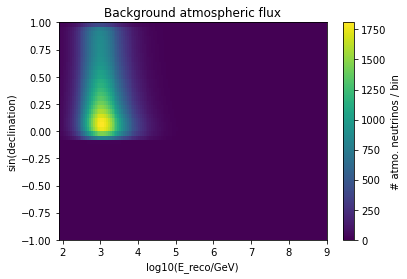

In [22]:
## atmo. background
plt.pcolormesh(logE_reco_bins, sindec_bins, k_b)
cb = plt.colorbar()
cb.set_label("# atmo. neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

Text(0.5, 1.0, 'Combined neutrino flux')

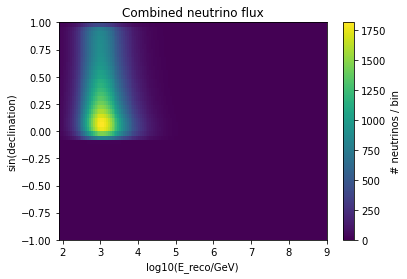

In [23]:
## atmo. background + astro. signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_i)
cb = plt.colorbar()
cb.set_label("# neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Combined neutrino flux")

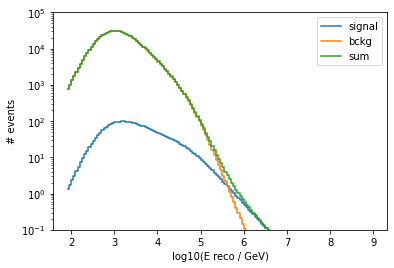

In [24]:
# summed 1D hist in log(E_reco)
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("log10(E reco / GeV)")
plt.ylabel("# events")
plt.ylim(1E-1, 1E5)
plt.legend()

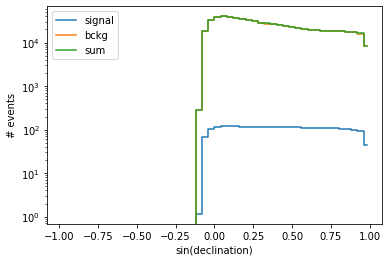

In [25]:
# summed 1D hist in sin(dec)
plt.plot(sindec_mids, k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(sindec_mids, k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(sindec_mids, k_i.sum(axis=1), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("sin(declination)")
plt.ylabel("# events")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$

In [28]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """
    Define the Log-Likelihood function depending
    on the model parameters (=fit parameters)
    
    fit parameters (= x) for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base, bckg_flux_vals * x[0]
    )
    mu_s = astro_flux(
        mu_s_base, emids, e_0, *x[1:]
    )
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (L) - L=Poisson
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )
 

The significance of the hypothesis test is evaluated using the test statistic

$TS = -2 \log ( H_0(\mu = {\rm best fit}) / H_1(\mu = {\rm best fit}) )$

where the best-fit parameters are obtained with an optimization function `fmin_l_bfgs_b`.


The data (k) is modeled as 'Asimov data', the TS calculation fulfills the requirements of Wilks' theorem, and thus we know that the underlying TS distribution
follows a $\chi ^2$ distribution, here with 2 degrees of freedom.

The p-value of the Asimov data set represents the expected significance of an analysis with real data if it has the same model parameters. It's the integral of the $\chi ^2$ distribution from TS to infinity (`chi.sf(TS)`). The p-value in terms of Gaussian standard deviations can be calculated via the inverse error function (`erfinv`).

In [27]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals)
k_s = astro_flux(
    aeff_factor,
    emids,
    E0,
    GAMMA, ## FIT PARAMETER
    1, ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~673312
print("Signal:", np.sum(k_s)) # ~2888
print("S+B", np.sum(k_i)) # ~676201

aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2, 0), aeff_factor, aeff_factor, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, aeff_factor, aeff_factor, k_i
)
# ... and fit both hypotheses!
# background first
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])
# .. then signal+background
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

## Note: out_bckg/comp[1] contains the value of the
# LLH function with the optimized model parameters
# out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

# calculate p-value and significance with Wilks' theorem and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Asimov data sum:
Background: 673312.6074227438
Signal: 2888.920442481476
S+B 676201.5278652253
Bckg-only normalization: [1.0042906]
Signal fit parameters: [0.99999943 2.3700677  1.00002791]
P-VALUE: 2.4755945656516476e-12 SIGNIFICANCE: 7.004676292334277
